# GPyTorch Regression Tutorial

***First of all, visit http://www.gaussianprocess.org/!***

Large part of BoTorch's tutorial utilize GPyTorch, as Gaussian Process is often the model of choice in Bayesian Optimization tasks. I am not sure I absolutely need this, but familiarizing myself with it won't hurt. 

## Training a RBF kernel Gaussian process on a simple function

$$ y = sin(2πx)+ϵ \\ 
error \quad ϵ∼N(0,0.04)$$

In [1]:
import math
import torch
import gpytorch
import matplotlib.pyplot as plt 

#%load_ext autoreload
#%autoreload 2

### training data

In [2]:
train_x = torch.linspace(0, 1, 100)
# output with some error
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

### Model

GPyTorch provides not a list of pre-defined GP models, but the necessary tools to build all kind of GP models for maximum flexibility.

A complete model should include
1. A GP Model  
    *`gpytorch.models.ExactGP`, for example
2. A Likelihood   
    * `gpytorch.likelihoods.GaussianLikelihood`, for example
3. A Mean  
    * `gpytorch.means.ConstantMean`, for example)
4. A Kernel: defines the prior covariance of the GP  
    * `gpytorch.kernels.Scalekernel(gpytorch.kernels.RBFKernel())`, for example
5. A MultivariateNormal 
    * `gpytorch.distributions.MultivariateNormal` for example

In [3]:
from gpytorch.distributions import MultivariateNormal
from gpytorch.means import ConstantMean
from gpytorch.models import ExactGP
from gpytorch.kernels import RBFKernel, ScaleKernel # Radial Basis Function
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.priors import GammaPrior

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        # Does some set up:
        # self.model_inputs = train_x 
        # self.model_targets = train_y
        # self.likelihood = likelihood
        
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel()) 
        # Remember the form of covariance determines the characteristics of
        # fitted function. from chaotic spiky to smooth / straight.
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

likelihood = GaussianLikelihood() # Assumes homoskedastic noise model
model = ExactGPModel(train_x, train_y, likelihood)

#### NOTE
homoscedasticity == "same variance"

Like most PyTorch module, ExactGP has .train() mode for training and .eval() mode for computing predictions.

### Training

Like in PyTorch, the training loop has to be written by the user.  

In [7]:
training_iter = 50

In [9]:
# Set the model and likelihood to training mode.
model.train()
likelihood.train()

# Just like usual PyTorch network model.
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "loss" for GP
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    optimizer.zero_grad()
    
    output = model(train_x)
    
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.926   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.894   lengthscale: 0.644   noise: 0.644
Iter 3/50 - Loss: 0.860   lengthscale: 0.598   noise: 0.598
Iter 4/50 - Loss: 0.822   lengthscale: 0.555   noise: 0.554
Iter 5/50 - Loss: 0.781   lengthscale: 0.514   noise: 0.513
Iter 6/50 - Loss: 0.735   lengthscale: 0.475   noise: 0.474
Iter 7/50 - Loss: 0.686   lengthscale: 0.438   noise: 0.437
Iter 8/50 - Loss: 0.637   lengthscale: 0.404   noise: 0.402
Iter 9/50 - Loss: 0.590   lengthscale: 0.371   noise: 0.370
Iter 10/50 - Loss: 0.546   lengthscale: 0.341   noise: 0.339
Iter 11/50 - Loss: 0.507   lengthscale: 0.315   noise: 0.311
Iter 12/50 - Loss: 0.470   lengthscale: 0.292   noise: 0.284
Iter 13/50 - Loss: 0.435   lengthscale: 0.272   noise: 0.260
Iter 14/50 - Loss: 0.401   lengthscale: 0.256   noise: 0.237
Iter 15/50 - Loss: 0.368   lengthscale: 0.244   noise: 0.216
Iter 16/50 - Loss: 0.335   lengthscale: 0.234   noise: 0.197
Iter 17/50 - Loss: 0.303   length

/home/hoseung/anaconda3/envs/tm38/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


### Make prediction

In [11]:
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0,1,51)
    observed_pred = likelihood(model(test_x))

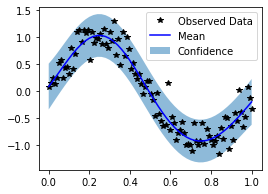

In [13]:
with torch.no_grad():
    f, ax = plt.subplots(1,1, figsize=(4,3))
    
    lower, upper = observed_pred.confidence_region()
    
    ax.plot(train_x.numpy(),train_y.numpy(), "k*")
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.legend(['Observed Data', 'Mean', 'Confidence'])